In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
# Load the CSV file containing labeled data
csv_file_path = "C:\\Users\\maniv\\Downloads\\ACIN Dataset.v2-acin_withmark.tensorflow\\test\\_annotations.csv"
data = pd.read_csv(csv_file_path)

# Extract filename, class, and bounding box coordinates from the CSV file
image_filenames = data['filename'].tolist()
class_labels = data['class'].tolist()
bounding_boxes = data[['xmin', 'ymin', 'xmax', 'ymax']].values

# Directory containing the images
image_dir = "C:\\Users\\maniv\\Downloads\\ACIN Dataset.v2-acin_withmark.tensorflow\\test"

# Load the images using their filenames
images = []
labels = []

for filename, class_label, bbox in zip(image_filenames, class_labels, bounding_boxes):
    image_path = os.path.join(image_dir, filename)
    img = cv2.imread(image_path)
    if img is not None:
        # Extract bounding box coordinates
        xmin, ymin, xmax, ymax = bbox
        # Resize image to a standard size if necessary
        img = cv2.resize(img, (100, 100))
        images.append(img.flatten())  # Flatten the image
        labels.append(class_label)
    else:
        print(f"Failed to load image: {image_path}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Train a machine learning model using the training data
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the trained model using the testing data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
joblib.dump(model, 'Downloads')

Accuracy: 0.7127739984882842
Precision: 0.7024160777021409
Recall: 0.7127739984882842
F1 Score: 0.699159538642802


['Downloads']

Cleanliness Rating for the Video: 1


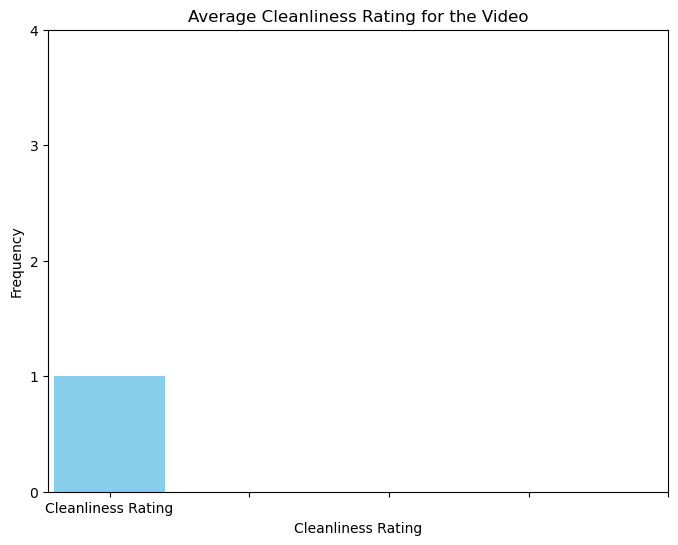

In [8]:
import joblib
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load the trained model
model = joblib.load('Downloads')  # Replace 'Downloads/model.pkl' with the actual path to your saved model

# Function to preprocess frame
def preprocess_frame(frame):
    # Resize frame to a standard size if necessary
    frame_resized = cv2.resize(frame, (100, 100))
    # Flatten the frame
    frame_flattened = frame_resized.flatten()
    return frame_flattened

# Function to classify cleanliness based on prediction probability
def classify_cleanliness(prediction_proba):
    if prediction_proba < 0.1:
        return 0
    elif 0.1 <= prediction_proba < 0.3:
        return 1
    elif 0.3 <= prediction_proba < 0.5:
        return 2
    elif 0.5 <= prediction_proba < 0.7:
        return 3
    else:
        return 4

# Function to make predictions and calculate average cleanliness rating for the entire video
def predict_and_rate_video(video_path, model):
    cap = cv2.VideoCapture(video_path)
    cleanliness_ratings = []

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video.")
        return None

    # Loop through frames in the video
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocess the frame
        frame_features = preprocess_frame(frame)
        # Make prediction using the trained model
        prediction_proba = model.predict_proba([frame_features])[0][1]  # Probability of class 1 (presence of object)
        cleanliness_rating = classify_cleanliness(prediction_proba)
        cleanliness_ratings.append(cleanliness_rating)

    # Release the video capture object
    cap.release()

    # Calculate the average cleanliness rating for the entire video
    if len(cleanliness_ratings) > 0:
        avg_cleanliness_rating = sum(cleanliness_ratings) // len(cleanliness_ratings)  # Convert to integer
        return avg_cleanliness_rating
    else:
        print("Error: No frames found in the video.")
        return None

# Load the video for testing
video_path = "C:\\Users\\maniv\\Downloads\\VID-20240327-WA0003.mp4"  # Replace with the actual path to your video file
avg_cleanliness_rating = predict_and_rate_video(video_path, model)
if avg_cleanliness_rating is not None:
    print("Cleanliness Rating for the Video:", avg_cleanliness_rating)

    plt.figure(figsize=(8, 6))
    plt.bar(["Cleanliness Rating"], [avg_cleanliness_rating], color='skyblue')
    plt.title("Average Cleanliness Rating for the Video")
    plt.xlabel("Cleanliness Rating")
    plt.ylabel("Frequency")
    plt.xticks(range(5))
    plt.yticks(range(5))
    plt.show()